# 1.0 Processing and Model Training

### 1.1 Introduction

Image super-resolution (SR) is the process of recovering high-resolution (HR) images from low-resolution (LR) images. It is an important class of image processing techniques in computer vision and image processing and enjoys a wide range of real-world applications, such as medical imaging, satellite imaging, surveillance and security, astronomical imaging, amongst others.

Image super-resolution (SR) problem, particularly single image super-resolution (SISR), has gained a lot of attention in the research community. SISR aims to reconstruct a high-resolution image ISR from a single low-resolution image ILR. Generally, the relationship between ILR and the original high-resolution image IHR can vary depending on the situation. Many studies assume that ILR is a bicubic downsampled version of IHR, but other degrading factors such as blur, decimation, or noise can also be considered for practical applications. Interpolation-based methods such as nearest-neighbor, bilinear, splines, etc., often introduce some side effects such as computational complexity, noise amplification, blurring results, etc., that are no longer the factors in deep-learning based non-linear methods to achieve super resolution.

### 1.2 Problem

Electron microscopy images are very noisy. As the resolution increases, signal to noise ratio (SNR) becomes poorer. In addition, loger exposure to reduce the noise is not feasible due to stage movement that introduces motion blur in the image. To avoid the motion blur, conventional approach is to collect many images with a shortest pssible exposure time where the stage motion effect can be ignored and register those images with some correlation method and average the pixels that are common to all the images. This averaged image constitue to one single image with high SNR. Unfortuntely, multiple exposure of the specimens to electron beam damages the specimen. Each short exposure image frames may differ in statistical features although they are imaging the same specimen. This degrades the image quality.
Is there a way to reduce the noise level in short exposure image frames and use only a few imge frames to average that can significantly increase the SNR of the image.

There is (in general) no relationship between the noise in neighboring pixels. Technical junkies call this “no correlation”. Correlation is the long-term average of the product of two signals N1 x N2. If two signals have no correlation, then the mean of their product is zero. The signal in neighboring pixels has a high degree of correlation. If you add uncorrelated signals, then their “power” is added, meaning the combined signal is the square root of the combined power.

N_comb = sqrt(N1^2+N2^2) and for N1 = N2 = N we get N_comb = sqrt(2)*N, where N1, N2 are root-mean-square (RMS) values of the noise.

However, if signals are highly correlated, then their sum is effectively the sum of their magnitudes:

S_comb = S1+S2 and for S1=S2=S we get S_comb = 2*S

So, if we add the content of two neighboring pixels, we get:

SNR_comb = S_comb/N_comb = sqrt(2)*(S/N)

So, the signal-to-noise increases by square root of two, which is about 40%.

We propose deep-learning encoder-decoder architecture to reduce the noise in individual short exposure time images (called image frames) while increasing the resolution by 4X upsampling. This significantlt reduces the noise and increases the SNR but is hard to mathematically quantify. The final image is down-sampled with conventional methods where every 2X down sampling increases the SNR by 40% as per above known theory.

### 2.0 Deep-learning processes

In [8]:
#Load general libaries to be used
import numpy as np
import glob
import skimage.io
import skimage.exposure
import cv2

In [34]:
#Load deep-learning libraries such as tensorflow and the easy to use wrappers for tensorflow methods using keras
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
path = "D:\\myData\\ML_Quality\\4X"
x_train_dataPath = path+"\\x_train_highres_4X\\*.png"
print(x_train_dataPath)
y_train_dataPath = path+"\\y_train_highres_4X\\*.png"
print(y_train_dataPath)

D:\myData\ML_Quality\4X\x_train_highres_4X\*.png
D:\myData\ML_Quality\4X\y_train_highres_4X\*.png


In [36]:
# Read training image pairs
files = glob.glob(x_train_dataPath, recursive=True)
print(len(files))

x_train=[]
x_valid=[]
ct=0;
for file in files: 
    img = skimage.io.imread(file)
    img = np.array(img)
    if ct%4 ==0:
        x_valid.append(img)
        ct=ct+1
    else:
        x_train.append(img)
        ct=ct+1
        

print(len(x_train))
print(len(x_valid))

print(x_train[0].shape)
print(x_valid[0].shape)

7002
5251
1751
(128, 128)
(128, 128)


In [37]:
ct=0

files = glob.glob(y_train_dataPath)
print(len(files))

### for noise reducer
xy_train=[]
xy_valid=[]
### for super resolution
y_train=[]
y_valid=[]

for file in files: 
    img = skimage.io.imread(file)         
    img = np.array(img)
    if ct%4 ==0:
        ct=ct+1
        y_valid.append(img)
        imgx = cv2.resize(img, x_train[0].shape, interpolation=cv2.INTER_AREA)
        xy_valid.append(imgx)
    else:
        y_train.append(img)
        imgx = cv2.resize(img, x_train[0].shape, interpolation=cv2.INTER_AREA)
        xy_train.append(imgx)
        ct=ct+1
        
print(len(xy_train))
print(len(xy_valid))
print(len(y_train))
print(len(y_valid))
print(xy_train[0].shape)
print(xy_valid[0].shape)
print(y_train[0].shape)
print(y_valid[0].shape)

7002
5251
1751
5251
1751
(128, 128)
(128, 128)
(512, 512)
(512, 512)


In [38]:
#some rearranging of data dimensions, etc.. to suit tensorflow requirements
x_train = np.dstack(x_train)
x_train = np.rollaxis(x_train,-1)
x_valid = np.dstack(x_valid)
x_valid = np.rollaxis(x_valid,-1)
xy_train = np.dstack(xy_train)
xy_train = np.rollaxis(xy_train,-1)
xy_valid = np.dstack(xy_valid)
xy_valid = np.rollaxis(xy_valid,-1)
y_train = np.dstack(y_train)
y_train = np.rollaxis(y_train,-1)
y_valid = np.dstack(y_valid)
y_valid = np.rollaxis(y_valid,-1)

In [39]:
###We also have to reshape our NumPy array as the current shape of the datasets is (Ntrain, X, Y, 1) and (Nvalid, X, Y, 1). 
###We need to add a fourth dimension with a single value (e.g., from (Ntrain, X, Y,1) to (Ntrain, X, Y, 1, 1));
x_train = x_train[:,:,:, tf.newaxis]
x_valid = x_valid[:,:,:, tf.newaxis]
xy_train = xy_train[:,:,:, tf.newaxis]
xy_valid = xy_valid[:,:,:, tf.newaxis]
y_train = y_train[:,:,:, tf.newaxis]
y_valid = y_valid[:,:,:, tf.newaxis]

print(x_train.shape) ## 1X
print(xy_train.shape) ## 1X for noise reducer
print(y_train.shape) ## 4X for super resolution

(5251, 128, 128, 1)
(5251, 128, 128, 1)
(5251, 512, 512, 1)


### 2.0.1 Encoder-Decoder based noise Reducer

Please note this code is only for demo (epoch=1 is set to show it compiles). Models with large number of epochs were built in office private clouds, compiled and tested.

In [40]:

########## Let us do ML based enhancement here ###################
img = Input(shape=(None, None, 1))   
############### let’s create the model with an object call ###################
#encoding architecture
x1 = Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(img) #64
x2 = Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1) #64
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3) #128
x5 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4) #128
x6 = MaxPool2D(padding='same')(x5)
x7 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6) #128
x8 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7) #128
x9 = MaxPool2D(padding='same')(x8)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x9) #256

## decoding architecture
y7 = UpSampling2D()(encoded)
y8 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(y7) #128
y9 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(y8) #128
y10 = Add()([x8, y9])
y11 = UpSampling2D()(y10)
y12 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(y11) #128
y13 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(y12) #128
y14 = Add()([x5, y13])
y15 = UpSampling2D()(y14)
y16 = Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(y15) #64
y17 = Conv2D(4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(y16) #64
y18 = Add()([x2, y17])
y19 = Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l1(10e-10))(y18) #32

decoded = Conv2D(1, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(y19)

autoencoder = Model(img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('noise_reducer_checkpoint.h5', save_best_only = True)

#train
#epoch=1 is just to show the code works as my home-PC is not capable of running large training datasets through many epochs
autoencoder.fit(x_train, 
                xy_train, 
                epochs=1, 
                validation_data=(x_valid, xy_valid),
                callbacks=[early_stopper, model_checkpoint])

#Actual saved model is from company computing environment where epochs=100 is used to fit the training data
autoencoder.save("D:\\myData\\ML_Quality\\autoencoder_NR.h5")

165/165 [==============================] - 21s 85ms/step - loss: 1342.9982 - accuracy: 0.0000e+00 - val_loss: 209.2892 - val_accuracy: 0.0000e+00


c:\users\umesh.adiga\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### 2.0.2 Super-resolution model builder

In [41]:
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.python.keras.models import Model

In [43]:
def normalize(x):
    return (x - 127.5) / 127.5
def denormalize(x):
    return x * 127.5 + 127.5
def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)
def res_block(x_in, filters, scaling):
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x
def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)
    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

In [45]:
##Some required parameters that define the deep-learning network
num_filters=32
num_res_blocks=8
res_block_scaling=None
scale=4

########## Let us do ML based 4X super-resolution enhancement here ###################
x_in = Input(shape=(None, None, 1))   
x = Lambda(normalize)(x_in)
x = b = Conv2D(num_filters, 3, padding='same')(x)
for i in range(num_res_blocks):
    b = res_block(b, num_filters, res_block_scaling)
b = Conv2D(num_filters, 3, padding='same')(b)
x = Add()([x, b])
x = upsample(x, scale, num_filters)
x = Conv2D(3, 3, padding='same')(x)
x = Lambda(denormalize)(x)
    
sr= Model(x_in, x, name="sr")
sr.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('super_resolution_checkpoint.h5', save_best_only = True)

#train
#epoch=1 is just to show the code works as my home-PC is not capable of running large training datasets through many epochs
sr.fit(x_train, y_train, epochs=1, validation_data=(x_valid, y_valid), callbacks=[early_stopper, model_checkpoint])

#Actual saved model is from company computing environment where epochs=100 is used to fit the training data
autoencoder.save("D:\\myData\\ML_Quality\\super_resolution_SR.h5")

165/165 [==============================] - 207s 1s/step - loss: 483.6505 - accuracy: 1.7383e-04 - val_loss: 374.7721 - val_accuracy: 1.4189e-04


### 3.0 Summary of Training and Model building: Overall architecture or sequence of processing

Instead of building one complex long deep-learning process, we have divided that into two parts of autoencoder-decoder model to reduce the noise and a super resolution model to increase the resolution by 4X. Thi is deliberately done to keep a greater control on what is happening inside the neural network in case the results are not as expected.
In the next report, we use some test data sets that were never seen during the training or validation and analyze the improvement in overall image quality.

## 4.0 Test the machine learning model

Here we collect some images that were never used for training and/or validation of the machine learning models. We process those images using
1. Noise reduction model: To reduce overall noise in the image
2. Super-resolution model: To increase the pixel count per unit area by 4X
The result of the noise reduction model is fed as an input to the super-resolution model
Finally, we reduce the super resolved image to its original size using cubic-spline interpolation. This down-sampling further increases the signal to noise ratio (40% for every 2X down-sampling)

Actual training was done with large number of epochs/iterations with training data adjusted readjusted several times. But the basic training code infrastructure remained the same. The final models after extensive training and corrections were then used for testing on new set of images. Because of that it appears as if the model stored in the above training process is not read here for testing. It is not exactly the same model but a same training with large number of iterations of training and then saved.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

In [4]:
model_NR = load_model("D:\\myData\\ML_Quality\\old_singleRes_models\\autoencoder_NR_1.h5")

In [6]:
test_dataPath = r"D:\myData\ML_Quality\x_test\medhigh\1\medhighRes_ML_SR_02\\00_in.png"

The code below is writte inside a for loop so that multiple images are read and tested

In [9]:
files = glob.glob(test_dataPath)

#### 4.1 Process the images

Here we implemented three similar functions. 
First one, uses only noise reduction model and demonstrates the effect of this model on a given image.
Second one, uses the super resolution model and scales the image 4X without blurring the image and with additional enhancements to contrast, etc. as learned by training process
In the third implementation we concatenated noise reduction and super resolution processes to take advantage of multiple models to improve the image quality.
Finally we bring the super resolved image back to original image size using cubic spline down-sampling there by further increasing the signal to noise ratio.

#### Only noise reduction

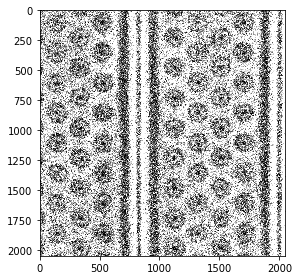

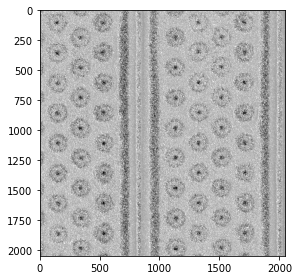

In [13]:
for file in files:   
    x_NR_test=[] # list to hold input image
    #read the image file
    img = skimage.io.imread(file)  
    skimage.io.imshow(img)
    plt.show()
    
    img = np.array(img, dtype=np.float)
    
    dim=img.shape # used to down size the image back to original size after super-resolution
    
    #pad the image to reduce boundary issues
    pad = 32
    img = np.pad(img, pad, mode="reflect")
    x_NR_test.append(img)
    
    ## do the necessary input data shape adjustments 9as required by tensorflow)
    x_NR_test = np.dstack(x_NR_test)
    x_NR_test = np.rollaxis(x_NR_test,-1)
    x_NR_test = x_NR_test[:,:,:, tf.newaxis]
    
    # do the noise reduction using NR model
    NR_predict = model_NR(x_NR_test)
    
    #use the noise reduced image to build super-resolution image
    img = NR_predict[0]
    img = img[:, :, 0] # back to 2D, 1 channel image
    img = img[pad:-pad, pad:-pad] # unpad the image
    
    # byte scale the image (0-255)
    img = (255*(img-np.min(img))/(np.max(img) - np.min(img)))
    img = np.array(img, dtype=np.uint8)
    ##write the output
    #skimage.io.imsave(result_path+"\\NR_"+os.path.basename(file), img)
    skimage.io.imshow(img)
    plt.show()

#### Only super-resolution

In [19]:
model_SR = load_model(r"D:\myData\ML_Quality\old_singleRes_models\autoencoder_NRSR_1.h5")

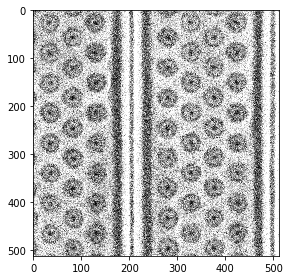

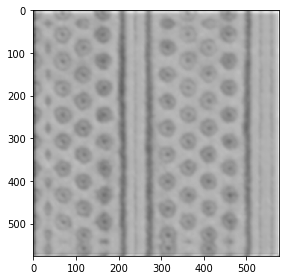

In [22]:
for file in files:   
    x_SR_test=[] # list to hold input image
    #read the image file
    img = skimage.io.imread(file)
    img = cv2.resize(img,(512, 512))
    skimage.io.imshow(img)
    plt.show()
    img = np.array(img, dtype=np.float)
    
    dim=img.shape # used to down size the image back to original size after super-resolution
    
    #pad the image to reduce boundary issues
    pad = 32
    img = np.pad(img, pad, mode="reflect")
    x_SR_test.append(img)
    
    ## do the necessary input data shape adjustments 9as required by tensorflow)
    x_SR_test = np.dstack(x_SR_test)
    x_SR_test = np.rollaxis(x_SR_test,-1)
    x_SR_test = x_SR_test[:,:,:, tf.newaxis]
    
    #do the super-resolution using SR model
    SR_predict = model_SR(x_SR_test)
    
    # write the image output
    img = SR_predict[0]
    img = img[:, :, 0]
    
    # resize the image to original image dimensions
    #img = cv2.resize(img, dim, interpolation=cv2.INTER_CUBIC) 
    
    #byte scale the image (0-255)
    img = (255*(img-np.min(img))/(np.max(img) - np.min(img)))
    img = np.array(img, dtype=np.uint8)
    ##write the output
    #skimage.io.imsave(result_path+"\\SR_"+os.path.basename(file), img)
    skimage.io.imshow(img)
    plt.show()

### Concatenating Noise Reduction and Super Resolution

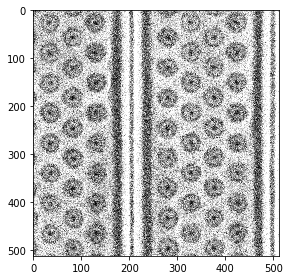

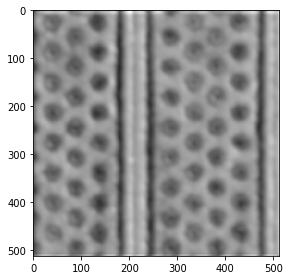

In [24]:
for file in files:   
    x_NR_test=[] # list to hold input image
    #read the image file
    img = skimage.io.imread(file)     
    img=cv2.resize(img, (512, 512))
    skimage.io.imshow(img)
    plt.show()
    img = np.array(img, dtype=np.float)
    
    dim=img.shape # used to down size the image back to original size after super-resolution
    
    #pad the image to reduce boundary issues
    pad = 32
    img = np.pad(img, pad, mode="reflect")
    x_NR_test.append(img)
    
    ## do the necessary input data shape adjustments 9as required by tensorflow)
    x_NR_test = np.dstack(x_NR_test)
    x_NR_test = np.rollaxis(x_NR_test,-1)
    x_NR_test = x_NR_test[:,:,:, tf.newaxis]
    
    # do the noise reduction using NR model
    NR_predict = model_NR(x_NR_test)
    
    #use the noise reduced image to build super-resolution image
    img = NR_predict[0]
    img = img[:, :, 0] # back to 2D, 1 channel image
    img = img[pad:-pad, pad:-pad] # unpad the image
    
    # byte scale the image (0-255)
    img = (255*(img-np.min(img))/(np.max(img) - np.min(img)))
    
    x_SR_test=[]
    # append the image to super resolution input list
    x_SR_test.append(img)
    
    # do the necessary list shape adjustments required for tensorflow
    x_SR_test = np.dstack(x_SR_test)
    x_SR_test = np.rollaxis(x_SR_test,-1)
    x_SR_test = x_SR_test[:,:,:, tf.newaxis]
    
    #do the super-resolution using SR model
    SR_predict = model_SR(x_SR_test)
    
    # write the image output
    img = SR_predict[0]
    img = img[:, :, 0]
    
    ## resize the image to original image dimensions
    #img = cv2.resize(img, dim, interpolation=cv2.INTER_CUBIC) 
    
    #byte scale the image (0-255)
    img = (255*(img-np.min(img))/(np.max(img) - np.min(img)))
    img = np.array(img, dtype=np.uint8)
    ##write the output
    #skimage.io.imsave(result_path+"\\"+os.path.basename(file), img)
    skimage.io.imshow(img)
    plt.show()

## 5.0 Summary

The above code reads images from a given folder, sets-up image into a appropriate dimension list (as required by tensorflow) and uses
1. Noise Reduction model (model_NR) to reduce the noise in the image using U-net based noise reduction technique
2. Super Resolution model (model_SR) to increase the X and Y dimensions of the image by 4X without blurring the image
In the final processing stage, we down-sample the super-resolved image to its original size (i.e. 4X down-sampling). This improves the signal to noise ratio substantially (40% for every 2X down-sizing) and in the end has not changed image dimensions but significantly improved image quality.

#### Results of image enhancement using individual models and the concatenation is shown in the final report. Model description and preliminary conclusions on the results is also reported.